In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-07-07 07:29:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-07 07:29:03 (121 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Get Data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-07-07 07:29:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  42.1MB/s    in 47s     

2023-07-07 07:29:54 (33.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_data= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode = "categorical")
test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode = "categorical",
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Model 1
Steps:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model(create own output layer)
* Compile model
* Feature ectract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data,to save epoch time)

In [4]:
# Create checkpoint callback
checkpoint_path = "transfer_learning/model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [5]:
# Create data augmentation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [6]:
# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # augment images(only in training phase)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="glob_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation = "softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [7]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 glob_avg_pool_layer (Global  (None, 1280)             0         
 AveragePooling2D)                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [8]:
#compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#fit
history_model_1 = model_1.fit(train_data,
                              epochs=5,
                              steps_per_epoch = len(train_data),
                              validation_data=test_data,
                              validation_steps = int(0.15*len(test_data)),
                              #track model training logs
                              callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 106s 386ms/step - loss: 3.3789 - accuracy: 0.2685 - val_loss: 2.4830 - val_accuracy: 0.4351
Epoch 2/5
237/237 [==============================] - 66s 277ms/step - loss: 2.1992 - accuracy: 0.4994 - val_loss: 2.0360 - val_accuracy: 0.5082
Epoch 3/5
237/237 [==============================] - 65s 272ms/step - loss: 1.8290 - accuracy: 0.5653 - val_loss: 1.8937 - val_accuracy: 0.5215
Epoch 4/5
237/237 [==============================] - 55s 233ms/step - loss: 1.5981 - accuracy: 0.6178 - val_loss: 1.8222 - val_accuracy: 0.5315
Epoch 5/5
237/237 [==============================] - 48s 201ms/step - loss: 1.4601 - accuracy: 0.6374 - val_loss: 1.7308 - val_accuracy: 0.5543


In [9]:
results_1 = model_1.evaluate(test_data)
results_1

790/790 [==============================] - 49s 62ms/step - loss: 1.5763 - accuracy: 0.5873


[1.5763030052185059, 0.5872871279716492]

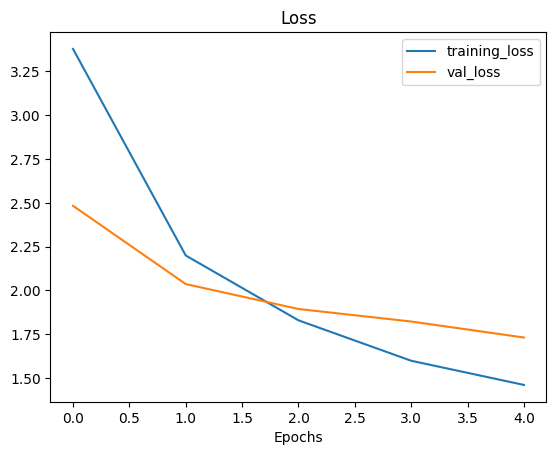

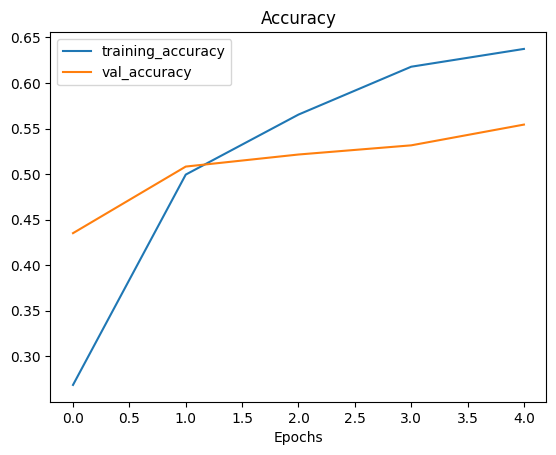

In [10]:
plot_loss_curves(history_model_1)

Ideally the two curves should be very similar to each other, if not it may suggest that our model is overfitting(performing too well on training data and not generalizing to unseen data).

# Fine-tuning

In [11]:
# Unfreeze all layers in base model
base_model.trainable = True

#Refreeze every layer exceot the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

# Recompile
model_1.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [12]:
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
glob_avg_pool_layer True
output_layer True


In [13]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine tune model_1
history_model_1_fine_tune = model_1.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps = int(0.15*len(test_data)),
                              initial_epoch = history_model_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 64s 229ms/step - loss: 1.2126 - accuracy: 0.6855 - val_loss: 1.7099 - val_accuracy: 0.5503
Epoch 6/10
237/237 [==============================] - 50s 211ms/step - loss: 1.1017 - accuracy: 0.7047 - val_loss: 1.7033 - val_accuracy: 0.5564
Epoch 7/10
237/237 [==============================] - 43s 181ms/step - loss: 1.0058 - accuracy: 0.7307 - val_loss: 1.6989 - val_accuracy: 0.5583
Epoch 8/10
237/237 [==============================] - 40s 167ms/step - loss: 0.9555 - accuracy: 0.7374 - val_loss: 1.6775 - val_accuracy: 0.5601
Epoch 9/10
237/237 [==============================] - 40s 166ms/step - loss: 0.8908 - accuracy: 0.7644 - val_loss: 1.6895 - val_accuracy: 0.5585
Epoch 10/10
237/237 [==============================] - 39s 163ms/step - loss: 0.8260 - accuracy: 0.7830 - val_loss: 1.6965 - val_accuracy: 0.5559


In [14]:
fine_tune_results_1 = model_1.evaluate(test_data)
fine_tune_results_1

790/790 [==============================] - 47s 60ms/step - loss: 1.4835 - accuracy: 0.6057


[1.4835339784622192, 0.6057029962539673]

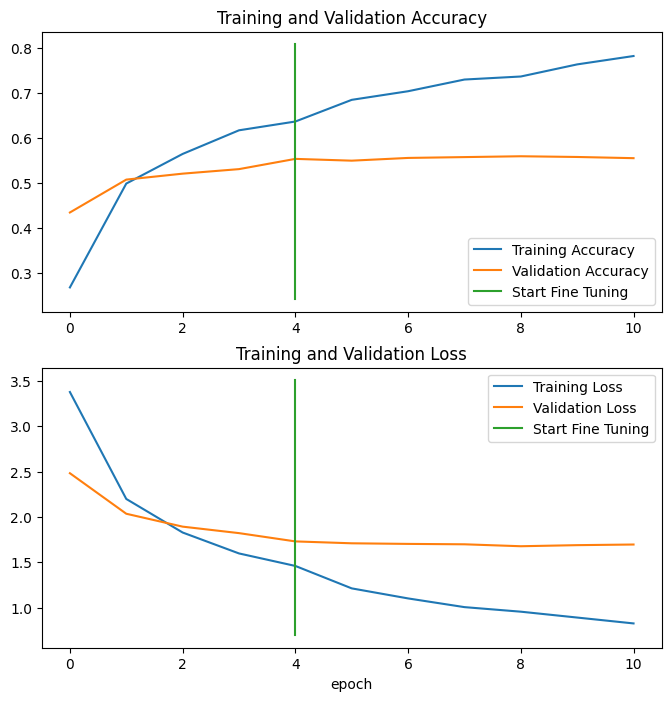

In [15]:
compare_historys(history_model_1,history_model_1_fine_tune,initial_epochs=5)

# Make Prediction
Lets make some preds, visualize them and then later find out which preds were the most wrong.

In [17]:
pred_probs = model_1.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 47s 56ms/step


In [18]:
len(test_data), len(pred_probs), 790*32

(790, 25250, 25280)

In [19]:
pred_probs.shape

(25250, 101)

In [20]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([1.67850226e-01, 1.05880383e-04, 1.36130080e-01, 3.23226089e-07,
        8.67577637e-06, 3.17457307e-06, 1.03599436e-04, 6.68866505e-06,
        1.49719389e-02, 3.01656488e-04, 1.38765404e-06, 2.37068198e-05,
        3.43610067e-04, 1.25249315e-07, 5.22791082e-03, 8.82742275e-03,
        7.04935446e-05, 3.05352645e-04, 2.70990469e-02, 1.49025063e-05,
        4.63202276e-04, 2.86844761e-06, 1.87979909e-04, 4.75891575e-05,
        1.24815363e-03, 2.73849932e-03, 2.48478423e-03, 6.09355557e-05,
        1.08853959e-01, 5.23921801e-04, 4.86569434e-06, 3.46054119e-04,
        5.94983634e-04, 1.51691083e-07, 2.84458371e-03, 1.41796063e-05,
        6.78412325e-05, 2.14943360e-03, 2.07053814e-02, 7.06399151e-05,
        1.74751636e-04, 4.01558261e-03, 3.06641625e-04, 2.18913337e-05,
        1.49820786e-04, 8.75236401e-06, 2.55339453e-03, 2.18955727e-04,
        2.46092281e-06, 4.73096259e-02, 1.70488100e-04, 9.64468418e-05,
        1.32584706e-01, 3.44918594e-02, 6.44119864e-05, 6.549331

In [21]:
print(f"The class with the hisghest predicted probability by the model 1 for sample 0: {pred_probs[0].argmax()}")

The class with the hisghest predicted probability by the model 1 for sample 0: 0


In [22]:
test_data.class_names[52]

'gyoza'

In [23]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [28]:
y_labels[-10:]

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

# Evaluating model 1 predictions
One way to check that our model predictions array is in the same order as our test labels array is to find accuracy score.

In [25]:
fine_tune_results_1

[1.4835339784622192, 0.6057029962539673]

In [26]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6057029702970297

# Confusion Matrix

In [27]:
from helper_functions import make_confusion_matrix
class_names = test_data.class_names

make_confusion_matrix(y_labels,pred_classes,classes=class_names,figsize=(100,100),text_size=20,savefig=True)

# Classification Report

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.16      0.22       250
           1       0.58      0.69      0.63       250
           2       0.61      0.64      0.62       250
           3       0.86      0.49      0.62       250
           4       0.58      0.38      0.46       250
           5       0.43      0.42      0.42       250
           6       0.70      0.80      0.75       250
           7       0.87      0.75      0.81       250
           8       0.24      0.62      0.35       250
           9       0.36      0.68      0.47       250
          10       0.50      0.45      0.47       250
          11       0.68      0.66      0.67       250
          12       0.70      0.60      0.65       250
          13       0.60      0.50      0.55       250
          14       0.56      0.52      0.54       250
          15       0.45      0.34      0.38       250
          16       0.67      0.57      0.62       250
          17       0.40    

In [33]:
# visualize f1 score
classification_dict = classification_report(y_labels,pred_classes,output_dict=True)
class_f1_scores={}
for k, v in classification_dict.items():
  if k == "accuracy": # stop once if get accuracy key
      break
  else:
      # add class names and f1 scores to new dict
      class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2209631728045326,
 'baby_back_ribs': 0.6302367941712202,
 'baklava': 0.624031007751938,
 'beef_carpaccio': 0.6224489795918366,
 'beef_tartare': 0.4615384615384615,
 'beet_salad': 0.42362525458248473,
 'beignets': 0.7467166979362102,
 'bibimbap': 0.8060344827586207,
 'bread_pudding': 0.35174746335963925,
 'breakfast_burrito': 0.4715672676837725,
 'bruschetta': 0.4745762711864407,
 'caesar_salad': 0.6734279918864098,
 'cannoli': 0.648068669527897,
 'caprese_salad': 0.545054945054945,
 'carrot_cake': 0.5371900826446281,
 'ceviche': 0.3835616438356165,
 'cheese_plate': 0.616052060737527,
 'cheesecake': 0.41025641025641024,
 'chicken_curry': 0.5299806576402322,
 'chicken_quesadilla': 0.6414253897550111,
 'chicken_wings': 0.7347740667976426,
 'chocolate_cake': 0.5683297180043383,
 'chocolate_mousse': 0.35587188612099646,
 'churros': 0.7310924369747899,
 'clam_chowder': 0.7117903930131005,
 'club_sandwich': 0.7247524752475248,
 'crab_cakes': 0.37827715355805247,
 'creme_brulee

In [34]:
classification_dict["99"]["f1-score"]

0.36861313868613144

In [35]:
# Turn f1 scores into df for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [36]:
f1_scores[:15]

,class_names,f1-score
33,edamame,0.974155
63,macarons,0.923077
69,oysters,0.857715
45,frozen_yogurt,0.849095
68,onion_rings,0.837398
86,sashimi,0.836000
65,mussels,0.833333
54,hot_and_sour_soup,0.832347
75,pho,0.831502
32,dumplings,0.829457


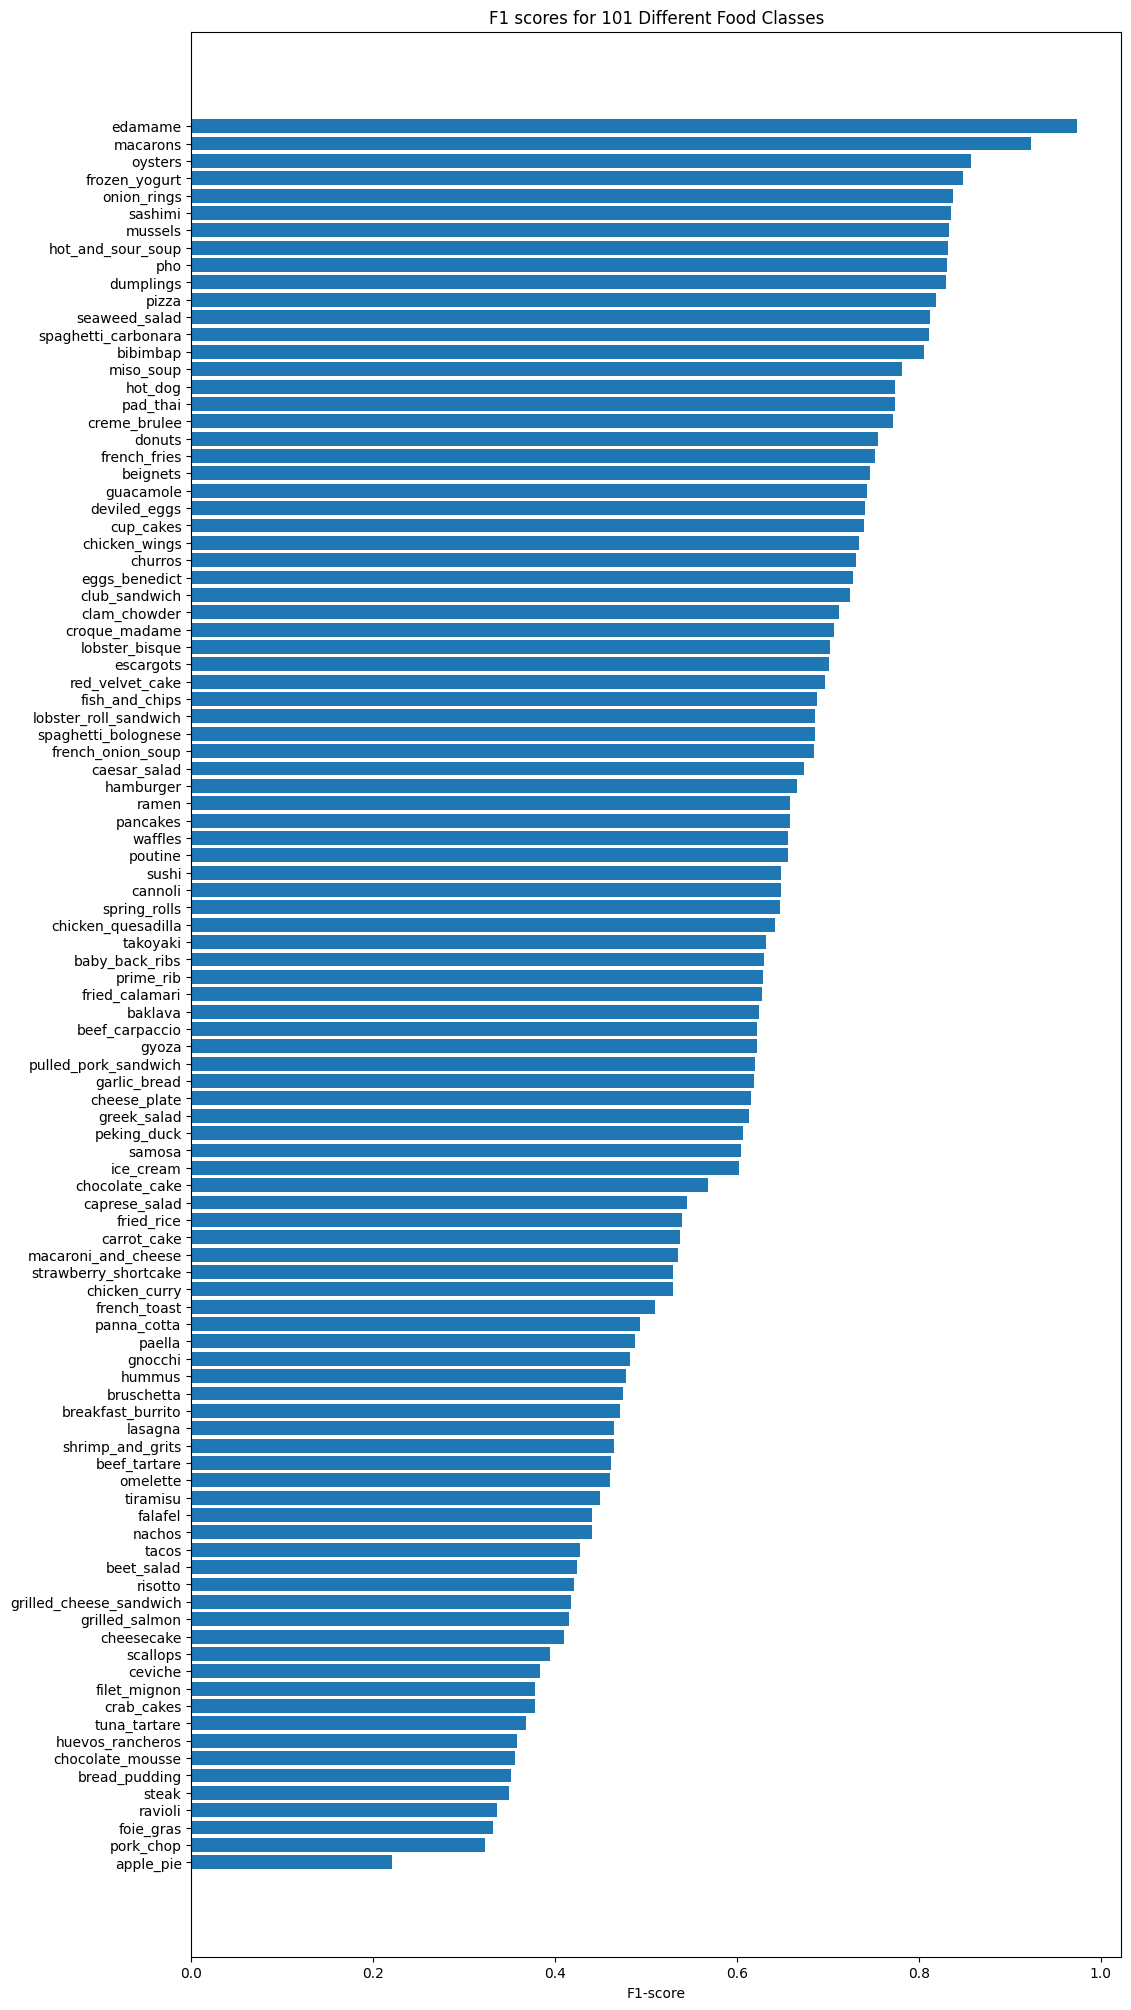

In [39]:
# Plot Df
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores= ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values) # get f1 score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 scores for 101 Different Food Classes")
ax.invert_yaxis();#reverse the order of plot

Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

* Read in a target image filepath using tf.io.read_file().
* Turn the image into a Tensor using tf.io.decode_image().
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.resize().
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [40]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

mage loading and preprocessing function ready.

Now let's write some code to:

* Load a few random images from the test dataset.
* Make predictions on them.
* Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 [==============================] - 0s 26ms/step


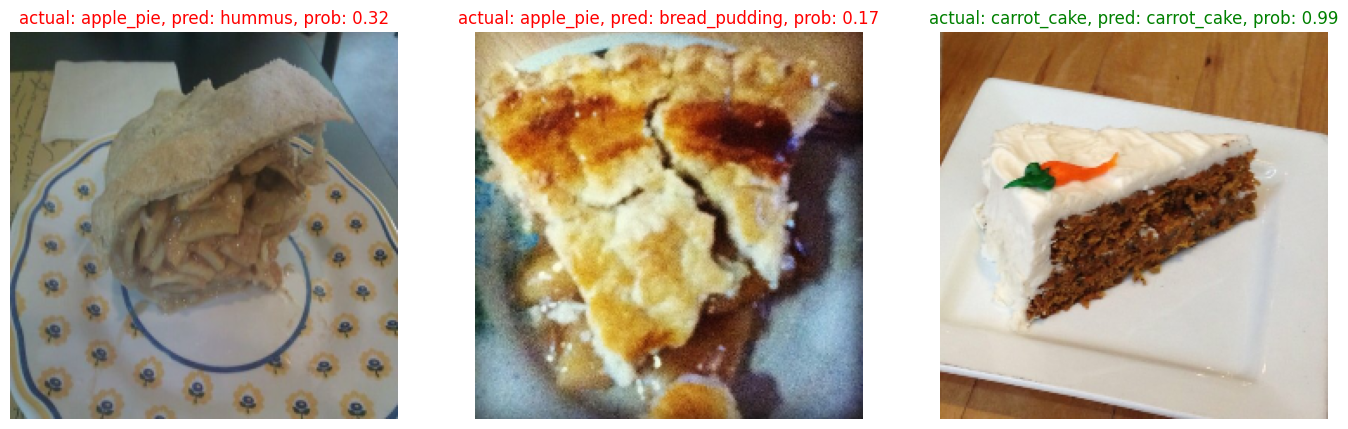

In [42]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);